In [213]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
import re
warnings.filterwarnings('ignore')
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
harmful_2_df = pd.read_csv('harmful_0_learning.csv')


harmful_url_dic = { 'blrblr':0,
                   
                   'sex': 1, 'porn': 1, 'gay': 1, 'tube': 1, 'pornhub':1,
                   'xxx': 1, 'fuck': 1, 'dick': 1, 'tit': 2,
                   'anal': 1, 'asian': 1, 'adult': 1, 'shemal': 1,'lesbian': 1,

                   'teen': 2, 'big': 2, 'girl': 2, 'pussi': 2, 'ass': 2, 'amateur': 2, 'matur': 2,
                   'cock': 2,'milf': 2, 'sexi': 2, 'babe':2, 'nud':2, 'nude': 2,
                   'blond': 2, 'blowjob': 2, 'cum': 2, 'young': 2,
                   'hardcor': 2, 'hardcore': 2 ,

                   'game': 3, 'casino': 3, 'play': 3, 'onlin': 3,'online':3, 
                   'card': 3,  'race': 3,  'admin': 3,

                   'escort': 4, 'servic': 4, 'service':4, 'agenc': 4,
                   'galleri': 4,'massag': 4, 'model': 4,'vip': 4, 'profil': 4,
                   
                   
                   'cam':5, 'video':5, 'chat':5, 'webcam': 5,
                   
                   'domain':7, 'domains':7, 'gateway':7
}

def word_idx(top20):
    list = top20.split()
    for word in list:
        if word in harmful_url_dic:
            return harmful_url_dic[word]
            break;
    return 0

def img_idx(num):
    if num < 10 : return 0
    elif (num >=10)&(num<50): return 1
    elif (num >=50)&(num<100): return 2
    elif (num >=100)&(num<200): return 3
    else: return 4

def child_idx(num):
    if num < 5 : return 0
    elif (num >=5)&(num<10): return 1
    elif (num >=10)&(num<25): return 2
    else: return 3

def img_child(img, child):
    if img >= child: return 0
    else: return 1
    
def url_idx(idx):
    if idx == 0: return 0
    else: return 1
    
def target(wi, ic, hw):
    if hw < 0.125 :
        if wi == 0: return 0
        elif wi == 7: return 7
        else: return wi
        
    elif hw >= 0.125 and hw < 0.5:
        if ic == 1 : return 6
        else: return wi
        
    # harmful_weight >= 0.5    
    else:
        if wi == 0 or wi ==7 : return 7
        elif ic == 1: return 6
        else: return wi
harmful_2_df['top_word'] = harmful_2_df['top_word'].fillna(" ")
harmful_2_df['top_word'] = harmful_2_df['top_word'].apply(lambda x : re.sub("[^a-zA-Z]"," ", x))

In [214]:
import math, sys
# from konlpy.tag import Twitter


class BayesianFilter:
    """ 베이지안 필터 """
    def __init__(self):
        self.words = set() # 출현한 단어 기록
        self.word_dict = {} # 카테고리마다의 출현 횟수 기록
        self.category_dict = {} # 카테고리 출현 횟수 기록
    # 형태소 분석하기 --- (※1)
    def split(self, text):
        results = []
        list = text.split()
        for word in list:
            results.append(word)
        return results
    # 단어와 카테고리의 출현 횟수 세기 --- (※2)
    def inc_word(self, word, category):
        # 단어를 카테고리에 추가하기
        if not category in self.word_dict:
            self.word_dict[category] = {}
        if not word in self.word_dict[category]:
            self.word_dict[category][word] = 0
        self.word_dict[category][word] += 1
        self.words.add(word)
    def inc_category(self, category):
        # 카테고리 계산하기
        if not category in self.category_dict:
            self.category_dict[category] = 0
        self.category_dict[category] += 1
    
    # 텍스트 학습하기 --- (※3)
    def fit(self, text, category):
        """ 텍스트 학습 """
        word_list = self.split(text)
        for word in word_list:
            self.inc_word(word, category)
        self.inc_category(category)
    
    # 단어 리스트에 점수 매기기--- (※4)
    def score(self, words, category):
        score = math.log(self.category_prob(category))
        for word in words:
            score += math.log(self.word_prob(word, category))
        return score
    
    # 예측하기 --- (※5)
    def predict(self, text):
        best_category = None
        max_score = -sys.maxsize 
        words = self.split(text)
        score_list = []
        for word in words:
            if word in harmful_url_dic:
                for category in self.category_dict.keys():
                    score = self.score(words, category)
                    score_list.append((category, score))
                    if score > max_score:
                        max_score = score
                        best_category = category
            else:
                for category in self.category_dict.keys():
                    score = self.score(words, 0)
                    score_list.append((category, 0))
                    if score > max_score:
                        max_score = score
                        best_category = category

        return best_category
    # 카테고리 내부의 단어 출현 횟수 구하기
    def get_word_count(self, word, category):
        if word in self.word_dict[category]:
            return self.word_dict[category][word]
        else:
            return 0
    # 카테고리 계산
    def category_prob(self, category):
        sum_categories = sum(self.category_dict.values())
        category_v = self.category_dict[category]
        return category_v / sum_categories
        
    # 카테고리 내부의 단어 출현 비율 계산 --- (※6)
    def word_prob(self, word, category):
        n = self.get_word_count(word, category) + 1 # ---(※6a)
        d = sum(self.word_dict[category].values()) + len(self.words)
        return n / d


bf = BayesianFilter()
for i in harmful_url_dic:
    bf.fit(i, harmful_url_dic[i])



In [215]:
print(harmful_2_df.shape)
harmful_2_df.head(3)

(60000, 9)


,url_id,url,url_harmful_idx,harmful_word_num,harmful_child_num,img_num,child_num,harmful_weight,top_word
0,156760,smitarana.in,0,5,0,5,33,0.125,call girl faridabad servic escort us client ge...
1,127479,mommy-tube.net,0,13,0,184,2,0.325,get fuck teen matur hot sex hard milf tit big ...
2,282130,shapeshifters.co,0,1,0,8,4,0.025,binder custom shapeshift made sport crop lengt...


In [216]:
harmful_2_df['word_idx'] = harmful_2_df['top_word'].apply(lambda x : bf.predict(x))
harmful_2_df['url_harmful_idx'] = harmful_2_df['url_harmful_idx'].apply(lambda x : url_idx(x))
harmful_2_df['img_child'] = harmful_2_df.apply(lambda x : img_child(x['img_num'],x['child_num']),axis=1)
harmful_2_df['img_num'] = harmful_2_df['img_num'].apply(lambda x : img_idx(x))
harmful_2_df['child_num'] = harmful_2_df['child_num'].apply(lambda x : child_idx(x))
 
harmful_2_df['target'] = harmful_2_df.apply(lambda x : target(x['word_idx'],x['img_child'],x['harmful_weight']),axis=1)

harmful_2_df.head(3)

,url_id,url,url_harmful_idx,harmful_word_num,harmful_child_num,img_num,child_num,harmful_weight,top_word,word_idx,img_child,target
0,156760,smitarana.in,0,5,0,0,3,0.125,call girl faridabad servic escort us client ge...,4.0,1,6.0
1,127479,mommy-tube.net,0,13,0,3,0,0.325,get fuck teen matur hot sex hard milf tit big ...,2.0,0,2.0
2,282130,shapeshifters.co,0,1,0,0,0,0.025,binder custom shapeshift made sport crop lengt...,0.0,0,0.0


In [196]:
print(harmful_2_df.shape)
harmful_2_df.describe()

(60000, 12)


,url_id,url_harmful_idx,harmful_word_num,harmful_child_num,img_num,child_num,harmful_weight,word_idx,img_child,target
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,207808.787633,0.150550,2.223717,0.247033,0.635733,0.419783,0.130868,1.735983,0.155683,2.074467
std,125625.392189,0.357613,2.770980,1.824992,0.865114,0.683501,0.211824,2.215301,0.362558,2.460770
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,97497.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,208689.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000
75%,330853.500000,0.000000,3.000000,0.000000,1.000000,1.000000,0.100000,4.000000,0.000000,4.000000
max,417389.000000,1.000000,19.000000,282.000000,4.000000,3.000000,0.975000,7.000000,1.000000,7.000000


In [217]:
value_counts=harmful_2_df['target'].value_counts()
print(value_counts)

0.0    32093
7.0    14155
3.0     4182
5.0     4032
4.0     2042
1.0     1302
6.0     1135
2.0     1052
Name: target, dtype: int64


In [219]:
view_df = harmful_2_df[['url_id','url','harmful_weight','target']]

In [224]:
view_df.loc[view_df['target'] == 1 ]

,url_id,url,harmful_weight,target
48,113042,tuber.space,0.200,1.0
50,10384,hugestraponlesbians.com,0.700,1.0
54,254644,fuckteenboy.com,0.850,1.0
88,58186,xnxx.media,0.400,1.0
105,223728,xhamster.nom.co,0.275,1.0
123,2360,avgirlsonline.com,0.900,1.0
175,388969,dating50plus.co.uk,0.200,1.0
249,126867,xnxx.pub,0.300,1.0
279,100910,moviesbysms.com,0.225,1.0
296,128396,younglesbianstube.com,0.875,1.0


In [191]:
view_df.loc[view_df['target'] == 2 ]

,url_id,url,harmful_weight,target
0,5,madteenies.com,0.750,2
1,15,porntube.com,0.750,2
11,156,tightpinkteens.com,0.725,2
16,175,fuckonwebcams.com,0.700,2
21,203,moneyshotpills.com,0.025,2
22,218,javidolphotos.com,0.125,2
26,240,asstube101.com,0.825,2
35,335,chinanews.life,0.375,2
38,357,sublimenetwork.com,0.200,2
44,420,gagged-bondage.com,0.200,2


In [210]:
harmDF = harmful_2_df[['url_harmful_idx','img_num','child_num','harmful_weight','word_idx']]
harmDF.data = harmDF.values.tolist()
harmDF.target = harmful_2_df[['target']]
harmDF.feature_names=['url_harmful_idx','img_num','child_num','harmful_weight','word_idx']
harmDF.target_names=['none','porn','teen','gambling','escort','cam','hub','domain']
harmDF.head(3)

,url_harmful_idx,img_num,child_num,harmful_weight,word_idx
0,0,0,3,0.125,4.0
1,0,3,0,0.325,2.0
2,0,0,0,0.025,0.0


In [211]:
tree = DecisionTreeClassifier(random_state=156)

X_train , X_test , y_train , y_test = train_test_split(harmDF.data, harmDF.target,
                                                       test_size=0.3,  random_state=11)


tree.fit(X_train, y_train)
pred = tree.predict(X_test)
print("훈련 세트 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(tree.score(X_test, y_test)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [179]:
depth = [2,4,6,8,9,10,12,14]
for x in depth:
    tree = DecisionTreeClassifier(max_depth=x, random_state=0)
    tree.fit(X_train, y_train)
    pred = tree.predict(X_test)
    print("Depth : ",x)
    print("훈련 세트 정확도: {:.3f}".format(tree.score(X_train, y_train)))
    print("테스트 세트 정확도: {:.3f}".format(tree.score(X_test, y_test)))



Depth :  2
훈련 세트 정확도: 0.549
테스트 세트 정확도: 0.553
Depth :  4
훈련 세트 정확도: 0.831
테스트 세트 정확도: 0.780
Depth :  6
훈련 세트 정확도: 0.926
테스트 세트 정확도: 0.853
Depth :  8
훈련 세트 정확도: 0.963
테스트 세트 정확도: 0.820
Depth :  9
훈련 세트 정확도: 0.980
테스트 세트 정확도: 0.873
Depth :  10
훈련 세트 정확도: 0.986
테스트 세트 정확도: 0.880
Depth :  12
훈련 세트 정확도: 0.989
테스트 세트 정확도: 0.873
Depth :  14
훈련 세트 정확도: 0.989
테스트 세트 정확도: 0.873


In [180]:
tree = DecisionTreeClassifier(max_depth=7, random_state=0)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)


print("훈련 세트 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(tree.score(X_test, y_test)))

훈련 세트 정확도: 0.951
테스트 세트 정확도: 0.840


In [181]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree2.dot", class_names=harmDF.target_names,
                feature_names=harmDF.feature_names, impurity=False, filled=True)

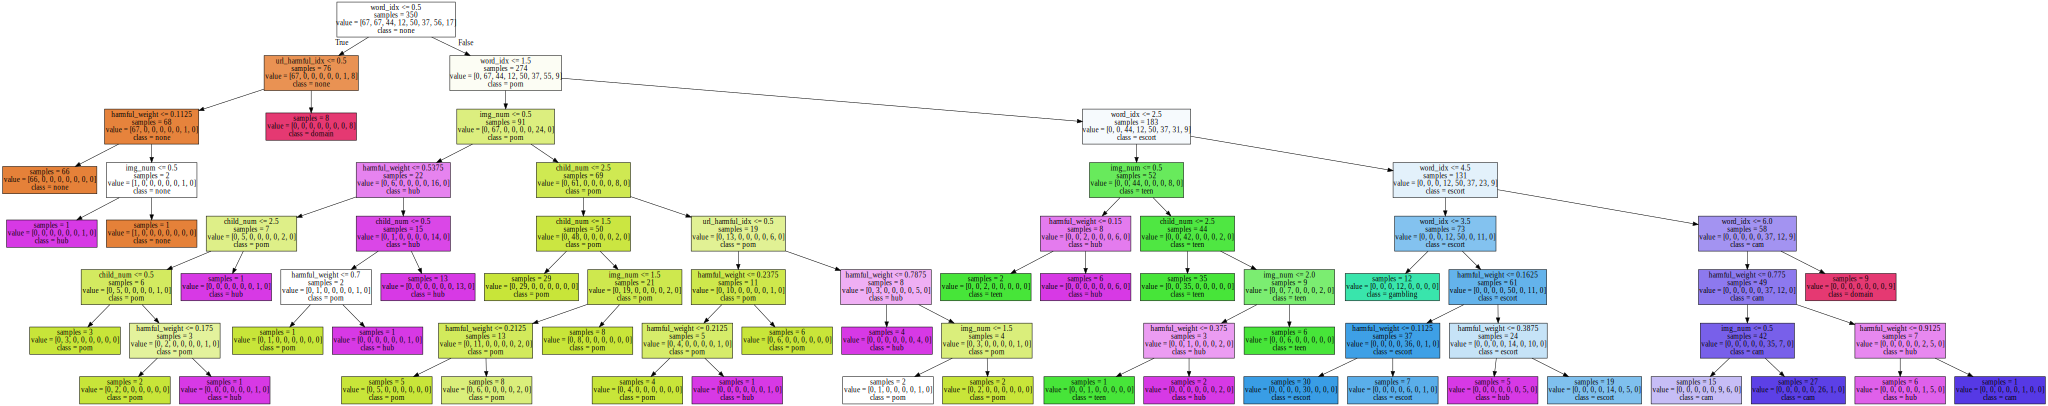

In [182]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree2.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Feature importances:
[ 0.061  0.092  0.02   0.109  0.718]
url_harmful_idx : 0.061
img_num : 0.092
child_num : 0.020
harmful_weight : 0.109
word_idx : 0.718


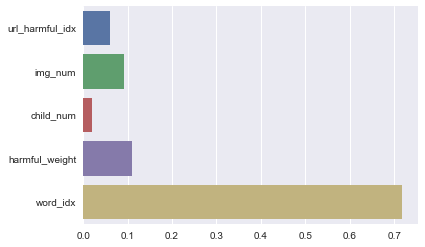

In [183]:
import seaborn as sns
import numpy as np
%matplotlib inline

# feature importance 추출 
print("Feature importances:\n{0}".format(np.round(tree.feature_importances_, 3)))

# feature별 importance 매핑
for name, value in zip(harmDF.feature_names , tree.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))

# feature importance를 column 별로 시각화 하기 
sns.barplot(x=tree.feature_importances_ , y=harmDF.feature_names)

In [184]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix
from sklearn.metrics import f1_score 

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred,average='macro')
    recall = recall_score(y_test , pred, average='macro')
    # F1 스코어 추가
    f1 = f1_score(y_test,pred, average='macro')
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
    
    
get_clf_eval(y_test,pred)
pred

오차 행렬
[[27  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  7  0]
 [ 0  0 21  0  0  0  1  0]
 [ 0  0  0 10  0  0  0  0]
 [ 0  0  0  0 17  0  2  0]
 [ 0  0  0  0  0 12  0  0]
 [ 0  3  0  1  6  4  6  0]
 [ 0  0  0  0  0  0  0  5]]
정확도: 0.8400, 정밀도: 0.8346, 재현율: 0.8687, F1:0.8472


array([2, 5, 2, 0, 4, 5, 2, 5, 4, 1, 1, 7, 2, 1, 2, 0, 3, 2, 5, 0, 6, 1, 6,
       6, 5, 0, 0, 0, 3, 4, 0, 4, 1, 1, 7, 6, 0, 3, 2, 6, 1, 1, 1, 3, 3, 4,
       1, 1, 3, 2, 0, 6, 6, 2, 5, 0, 7, 0, 5, 0, 4, 1, 4, 0, 2, 4, 5, 7, 0,
       6, 6, 6, 0, 5, 0, 2, 1, 5, 4, 6, 6, 5, 1, 6, 3, 1, 0, 2, 1, 1, 6, 3,
       1, 4, 1, 1, 0, 4, 0, 2, 4, 4, 4, 4, 5, 0, 0, 5, 5, 1, 0, 1, 2, 4, 1,
       5, 4, 0, 3, 1, 1, 1, 2, 4, 6, 2, 1, 3, 0, 4, 1, 3, 1, 0, 0, 7, 1, 2,
       4, 2, 6, 4, 4, 0, 1, 2, 2, 2, 4, 5], dtype=int64)